In [110]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import warnings


warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


import itertools
from sklearn.metrics import mean_squared_error as mse
import pickle, joblib
from pathlib import Path
import seaborn as sns

# Устанавливаем параметры холста для всех графиков matplotlib
sns.set(palette='Set2', font_scale=1.2)

Загрузите файл `electricity.csv` (<a href="https://rdrr.io/cran/stR/man/electricity.html">источник</a>) c информацией о максимальном спросе на электричество (`Consumption`) в штате Виктория (Австралия) за 30-минутные интервалы с 10 января 2000 в течении 115 дней, а так же информация о температуре воздуха (`Temperature`) за эти же промежутки времени.

In [121]:
df = pd.read_csv("electricity.txt", index_col=0)
df.head()

,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
1,3853.475392,20.90,0,0,48
2,3683.014105,20.70,1,1,49
3,3912.324031,20.50,2,2,50
4,3783.881181,20.05,3,3,51
5,3554.257244,19.60,4,4,52


In [3]:
df.shape

(5520, 5)

In [4]:
# Проверим точно ли данные уже отсортированы как это кажется из семпла данных
if df.Time.is_monotonic:
    print("Данные отсортированы")
else:
    print("Данные нужно отсортировать")

Данные отсортированы


Нарисуйте графики временных рядов температуры и потребления электричества. Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используйте коэффициенты корреляции, учитывая условия их применимости.

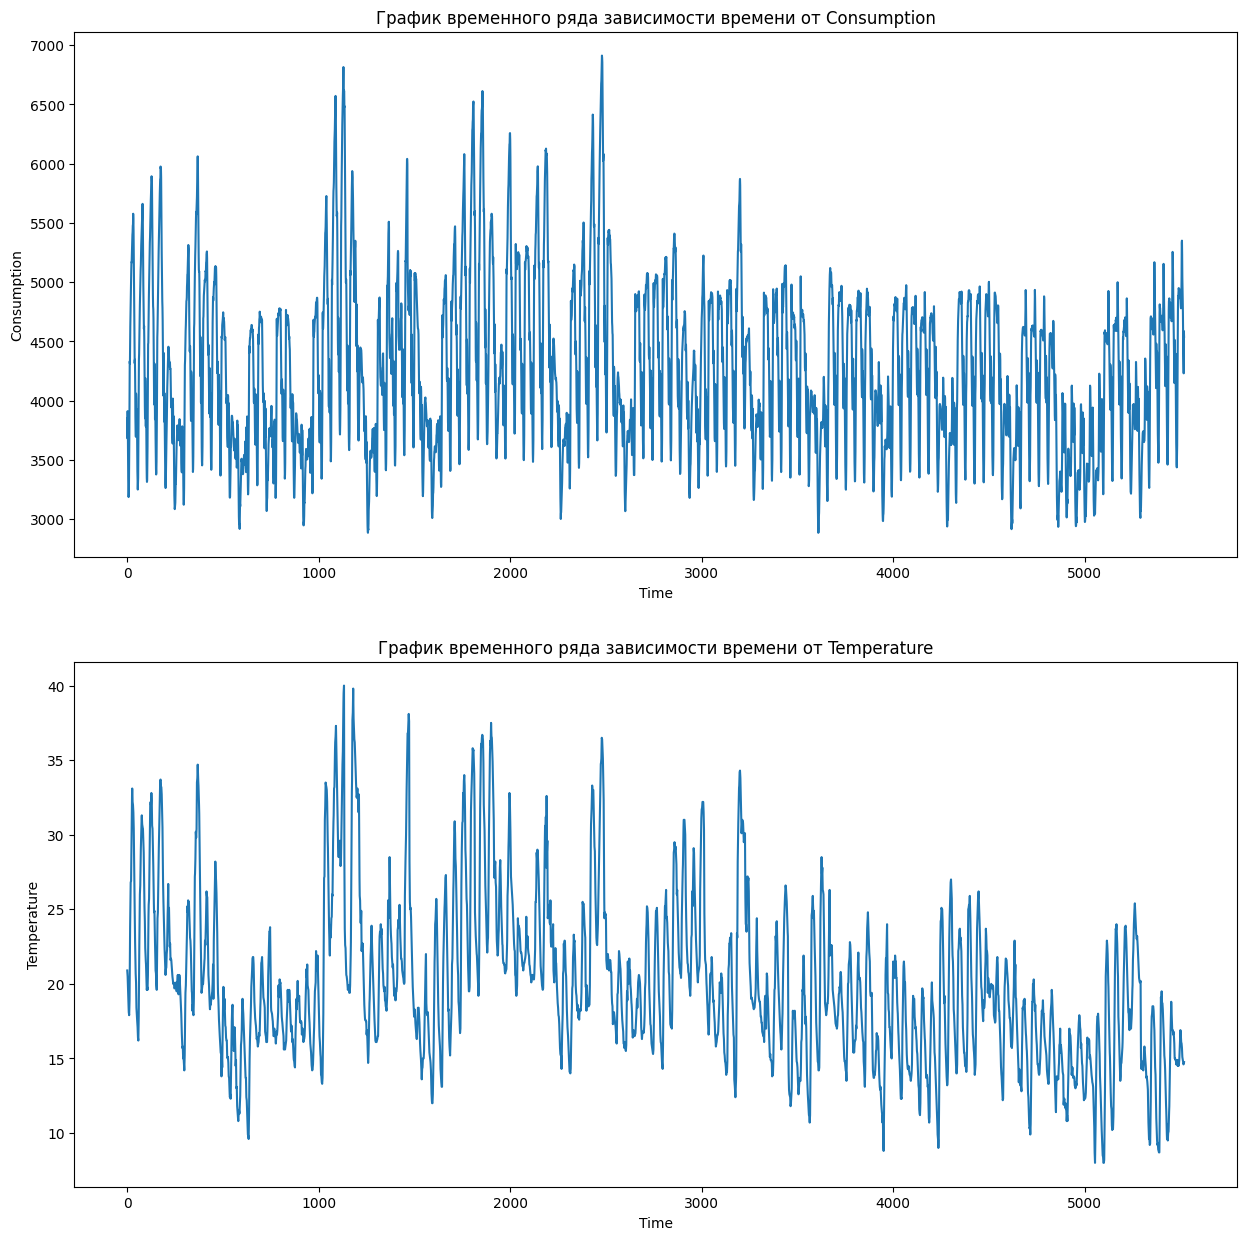

In [5]:
# Построим графики
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
columns = df.columns[:2]

for ax, col in zip(axes, columns):
    ax.set_title(f'График временного ряда зависимости времени от {col}')
    ax.set_xlabel(f'Time')
    ax.set_ylabel(f'{col}')
    ax.plot(df.Time, df[col])
fig.show()

In [11]:
# Посчитаем корреляцию
"""
Условия применимости корреляции Пирсона: распределение переменных должно быть близко к нормальному
и количество значений переменных должно быть равно.
"""
# Проверим нормальное распределение в переменных
norm_cons = shapiro(df.Consumption)
norm_temp = shapiro(df.Temperature)
if norm_cons[1] >= 0.05:
    print("Переменная Consumption распределена нормально")
else:
    print("Переменная Consumption распределена ненормально")
    
if norm_temp[1] >= 0.05:
    print("Переменная Temperature распределена нормально")
else:
    print("Переменная Temperature распределена ненормально")

Переменная Consumption распределена ненормально
Переменная Temperature распределена ненормально


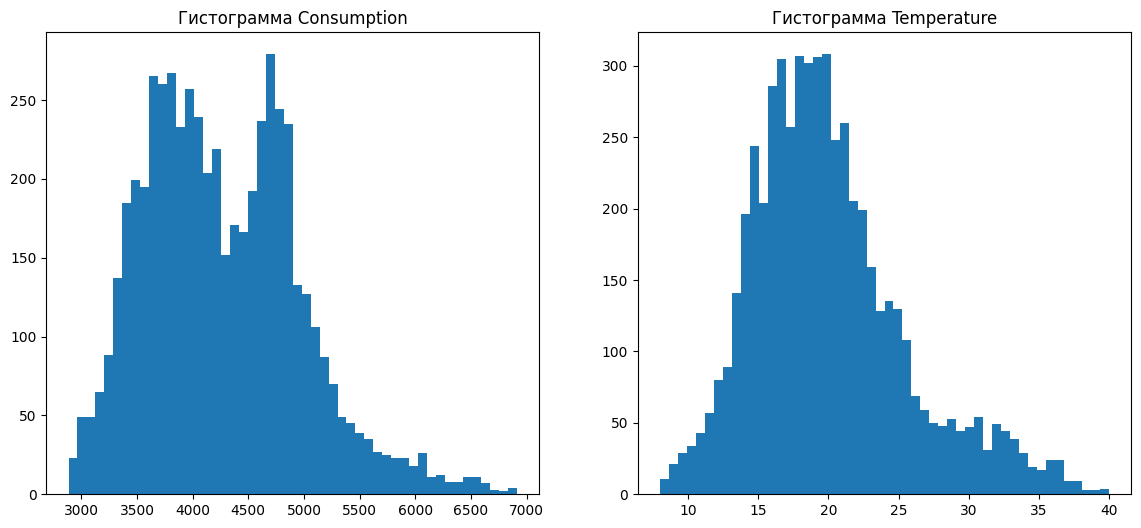

In [16]:
# Посмотрим глазами на распределение чтобы убедиться что распределение ненормальное
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
columns = df.columns[:2]

for ax, col in zip(axes, columns):
    ax.set_title(f'Гистограмма {col}')
    ax.hist(df[col], bins=50)
fig.show()

Видим что распределение Consumption бимодальное, нормальным его точно не назовешь. Распределение Temperature ближе к нормальному, но хвосты тоже делают распределение ненормальным. Поэтому воспользуемся непараметрическим аналогом Пирсона - коэффициентом корреляции Спирмена.

In [25]:
# Найдем корреляцию
koef_sp = spearmanr(df.Consumption, df.Temperature)
stat_res = "значимой" if koef_sp[1] <= 0.05 else "не значимой"
print(f"Коэффициент корреляции {round(koef_sp[0], 2)}, корреляция является статистически {stat_res}")

Коэффициент корреляции 0.58, корреляция является статистически значимой


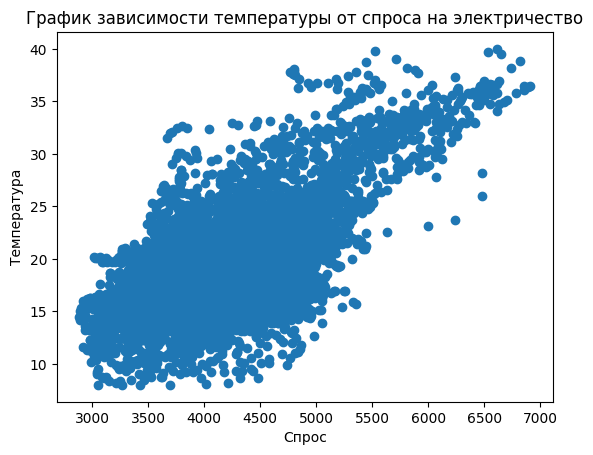

In [32]:
# Построим график зависимости переменных друг от друга
plt.scatter(df.Consumption, df.Temperature)
plt.title("График зависимости температуры от спроса на электричество")
plt.xlabel("Спрос")
plt.ylabel("Температура")
plt.show()

### Ответ  
Зависимость температуры от потребления существует. Чем выше температура, тем выше потребление.

Разделите временной ряд на две части:
данные за последнюю неделю (последние $48\times7$ измерений) назовем тестовыми данными, а все остальное &mdash; обучающими данными.

In [39]:
size_train = df.shape[0] - 48 * 7
test = df.iloc[size_train:]
train = df[~df.index.isin(test.index)]

Сколько типов сезонностей можно выделить в каждом из двух рядов &mdash; спрос на электричество и температура?
С помощью STL-декомпозиции и с помощью декомпозиции, основанной на скользящих средних, в каждом ряде выделите тренд, все типы сезонности, остатки. Сравните 2 метода друг с другом.

Мы можем выделить дневные интервалы так как потребление, как и температура высокие днем и низкие ночью и также в потреблении заметны недельные интервалы - потребление высокое в рабочие дни и падает в выходные, насколькоя предполагаю. В температуре больше одного дневного интервала я выделить не могу так как данные у нас за 115 дней и здесь нет повторения сезона.

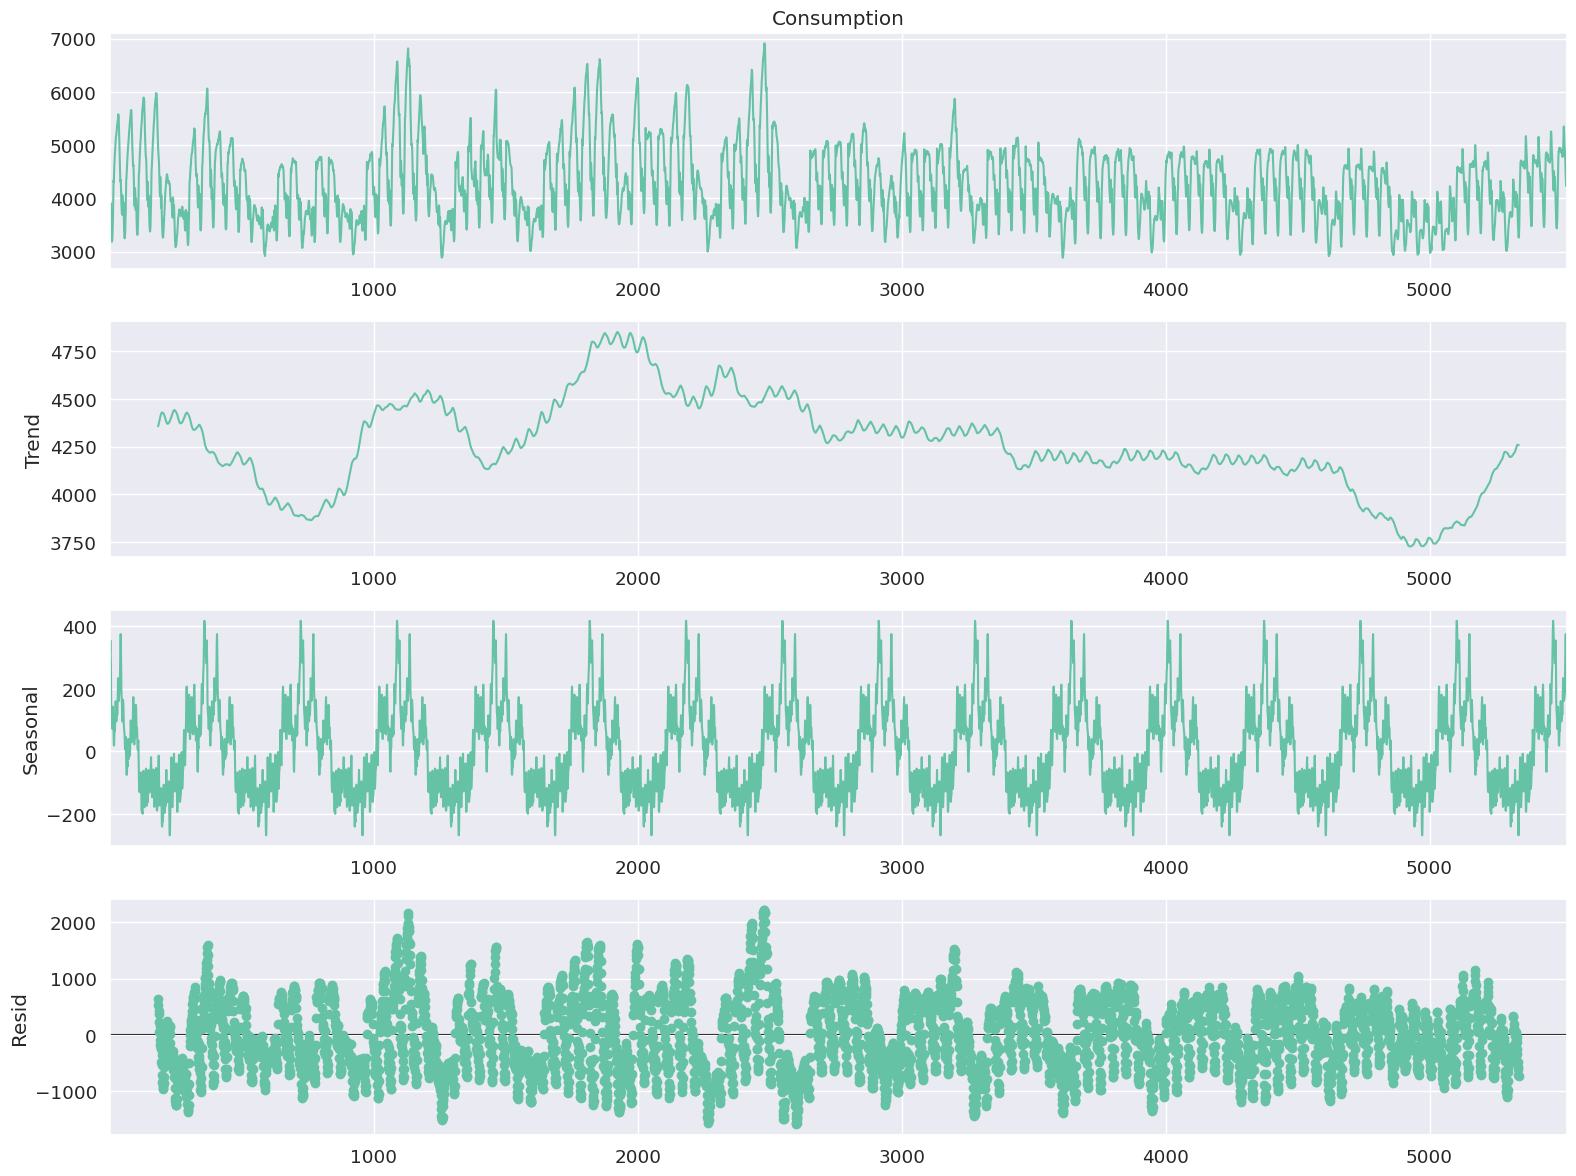

In [89]:
# Применим простую декомпозицию со скользящим средним
simple_decompose = seasonal_decompose(df.Consumption, model='additive', two_sided=True, period=365)
simple_decompose.plot()
plt.rc("figure", figsize=(16, 12))

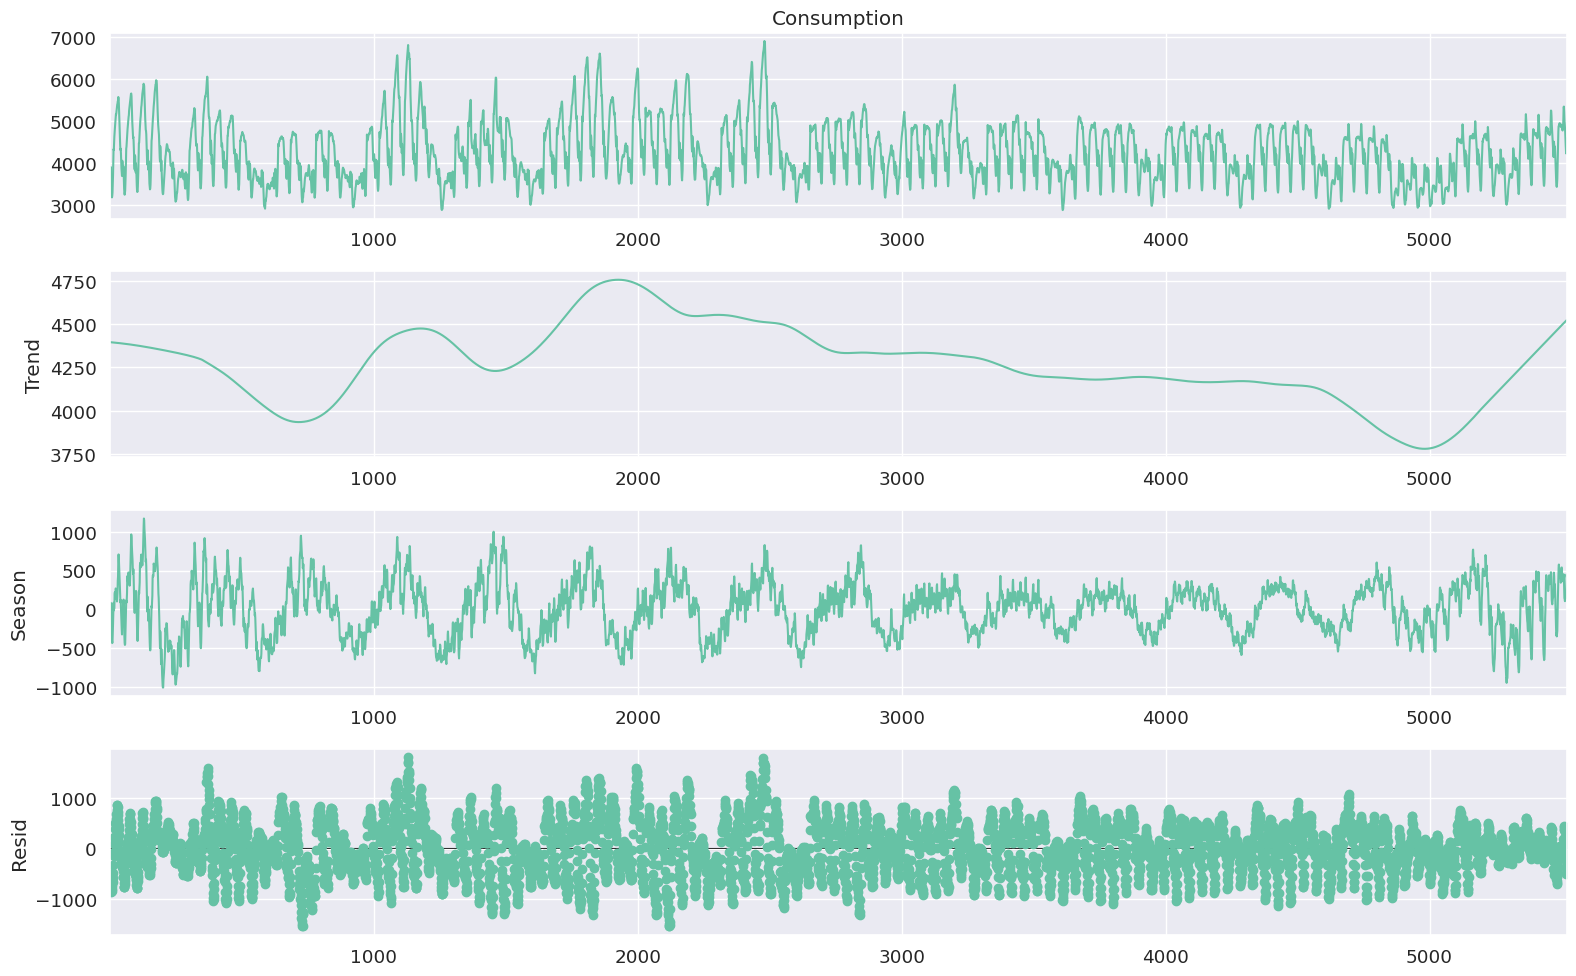

In [85]:
# применим STL для декомпозиции временных рядов
stl_decompose_model = STL(df.Consumption, period=365, seasonal=7, trend=None)

stl_decompose = stl_decompose_model.fit()
stl_decompose.plot()
plt.show()
plt.rc("figure", figsize=(16, 12))

В STL декомпозиции смущает что остатки распределены не очень нормально, на первый взгляд.

STL сработал лучше потому что и линию тренда сглажена лучше и сезонность изменяется аналогично тому как изменяется сам график, простая декомпозиция этого не учла.

С помощью критериев KPSS и Дики-Фуллера проверьте на стационарность исходные ряды и остатки, полученные после применения STL-декомпозиции.

KPSS: H0 - ряд стационарен, H1 - ряд не стационарен

In [95]:
stationary_consumption = kpss(df.Consumption)[1]
stationary_temperature = kpss(df.Temperature)[1]

pr_cons = "стационарен" if stationary_consumption >= 0.05 else "не стационарен"
pr_temp = "стационарен" if stationary_temperature >= 0.05 else "не стационарен"

print(f"Согласно тесту KPSS ряд Consumption {pr_cons}, а ряд Temperature {pr_temp}")

Согласно тесту KPSS ряд Consumption не стационарен, а ряд Temperature не стационарен


In [96]:
stationary_consumption_adf = adfuller(df.Consumption)[1]
stationary_temperature_adf = adfuller(df.Temperature)[1]

pr_cons = "стационарен" if stationary_consumption_adf >= 0.05 else "не стационарен"
pr_temp = "стационарен" if stationary_temperature_adf >= 0.05 else "не стационарен"

print(f"Согласно тесту KPSS ряд Consumption {pr_cons}, а ряд Temperature {pr_temp}")

Согласно тесту KPSS ряд Consumption не стационарен, а ряд Temperature не стационарен


Оба теста показали что временные ряды не стационарны. Посмотрим на стационарность остатки временных рядов

In [104]:
resid_consumprtion = stl_decompose.resid

stl_decompose_model2 = STL(df.Temperature, period=365, seasonal=7, trend=None)
stl_decompose2 = stl_decompose_model2.fit()
resid_temperature = stl_decompose2.resid

In [107]:
stationary_consumption_resid = kpss(resid_consumprtion)[1]
stationary_temperature_resid = kpss(resid_temperature)[1]

pr_cons = "стационарны" if stationary_consumption_resid >= 0.05 else "не стационарны"
pr_temp = "стационарны" if stationary_temperature_resid >= 0.05 else "не стационарны"

print(f"Согласно тесту Дики-Фуллера остатки ряда Consumption {pr_cons}, остатки ряда Temperature {pr_temp}")

Согласно тесту Дики-Фуллера остатки ряда Consumption стационарны, остатки ряда Temperature стационарны


In [133]:
stationary_consumption_resid = kpss(resid_consumprtion)[1]
stationary_temperature_resid = kpss(resid_temperature)[1]

pr_cons = "стационарны" if stationary_consumption_resid >= 0.05 else "не стационарны"
pr_temp = "стационарны" if stationary_temperature_resid >= 0.05 else "не стационарны"

print(f"Согласно тесту KPSS остатки ряда Consumption {pr_cons}, остатки ряда Temperature {pr_temp}")

Согласно тесту KPSS остатки ряда Consumption стационарны, остатки ряда Temperature стационарны


In [109]:
stationary_consumption_adf_resid = adfuller(df.Consumption)[1]
stationary_temperature_adf_resid = adfuller(df.Temperature)[1]

pr_cons = "стационарны" if stationary_consumption_adf_resid >= 0.05 else "не стационарны"
pr_temp = "стационарны" if stationary_temperature_adf_resid >= 0.05 else "не стационарны"

print(f"Согласно тесту Дики-Фуллера остатки ряда Consumption {pr_cons}, остатки ряда Temperature {pr_temp}")

Согласно тесту Дики-Фуллера остатки ряда Consumption не стационарны, остатки ряда Temperature не стационарны


In [ ]:
Тест kpss указал на стационарность остатков рядов спроса и температуры, а тест Дики-Фуллера нет. Это означает 

С помощью экспоненциального сглаживания, модели Хольта и модели Хольта-Уинтерса постройте прогнозы модели с оптимальными параметрами **спроса на электричество** на неделю вперед. Посчитайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику MSE. Сравните все предсказания.

In [112]:
ExponentialSmoothing, SimpleExpSmoothing, 

In [166]:
holt_model = Holt(train.Consumption, initialization_method="estimated").fit()

In [167]:
holt_pred = holt_model.predict(start=5185, end=5520)

In [169]:
mse_holt = mse(test.Consumption, holt_pred)

In [173]:
SimpleExpSmoothing(train.Consumption, initialization_method="estimated").fit().predict(start=5183, end=5520)

5183    4328.727794
5184    4317.442980
5185    4317.442980
5186    4317.442980
5187    4317.442980
           ...     
5516    4317.442980
5517    4317.442980
5518    4317.442980
5519    4317.442980
5520    4317.442980
Length: 338, dtype: float64

In [174]:
train.Consumption.tail()

5180    4131.878165
5181    4023.872303
5182    3968.512667
5183    4330.536516
5184    4317.386273
Name: Consumption, dtype: float64

Я не очень понял как заставить экспоненциальное сглаживание предсказывать значение, сглаживать некоторые последние значения, а не брать последнее значение. Поэтому не смог посчитать mse для этих методов.